In [1]:
import msprime, tskit
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

intro

In [2]:
sample_size = 20 #number of samples per deme

mig = 3.8866e-7
seqLength = 32e3 
recr = 1.84675e-8
Ne0 = 2.3241e6
Ne1 = 9.8922e5 
splitT = 4.8580e6
mu = 1.9e-9

population_configurations = [
    msprime.PopulationConfiguration(sample_size=sample_size, initial_size=Ne0),
    msprime.PopulationConfiguration(sample_size=sample_size, initial_size=Ne1),
    ]
    
#demographic events: specify in the order they occur backwards in time
demographic_events = [
    msprime.PopulationParametersChange(time=splitT, initial_size=Ne0, population_id=0),
    msprime.MassMigration(time=splitT, source=1, destination=0, proportion=1.0),
    msprime.MigrationRateChange(splitT, 0)
    ]

In [ ]:
seed = np.random.randint(1, 2**32 - 1, num_replicates)

replicates = msprime.simulate(
        num_replicates = 1,
        length = seqLength, 
        recombination_rate = recr,
        population_configurations = population_configurations,
        demographic_events = demographic_events,
        migration_matrix = [[0,0],
                            [mig,0]],
        mutation_rate = mu,
        random_seed=seed)

In [ ]:
for ts, index in enumerate(replicates):
    msprime.mutate(ts, rate=mu, keep=True)
    with open(directory+'sim{}.vcf'.format(str(index)), 'w') as vcf_file:
        ts.write_vcf(vcf_file, ploidy=2)
    ts.dump(directory+'sim{}.trees'.format(str(index)))

or run all this in in script that can be run on multiple cores
change parametes within sim_chuncks.py as desired

In [ ]:
%run sim_chuncks.py

run tskit Fst scan and
analyse output using script as provided in the Fst_istogram notebook

In [ ]:
#simulate replicates with different recombination rates cfr. windows 
#specify a distribution to draw values from
recomb = abs(np.random.normal(loc=1.846, scale=0.1, size=300))/1e8
replicates = msprime.simulate(
        num_replicates = 1,
        length = seqLength, 
        recombination_rate = recr,
        population_configurations = population_configurations,
        demographic_events = demographic_events,
        migration_matrix = [[0,0],
                            [mig,0]],
        mutation_rate = mu)

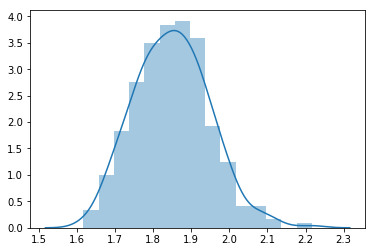

In [8]:
sns.distplot(abs(np.random.normal(loc=1.846, scale=0.1, size=300))/1e8)